In [1]:
from keras.layers import *
from keras.layers import LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
df = pd.read_csv('archive 3\sign_mnist_train.csv')

In [3]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [4]:
generator = 0
discriminator = 0
images = 0

In [5]:
images = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    pixels = row.drop('label')
    images.append(pixels.to_numpy().reshape((28,28, 1)))

images = np.array(images) / 255

100%|██████████| 27455/27455 [00:18<00:00, 1488.06it/s]


In [6]:
GENERATE_RES = 1 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 28 # rows/cols (should be square)
IMAGE_CHANNELS = 1

# Preview image 
PREVIEW_ROWS = 7
PREVIEW_COLS = 7
PREVIEW_MARGIN = 5

# Size vector to generate images from
SEED_SIZE = 100

BATCH_SIZE = 32

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 28px square images.


In [7]:
def build_generator(seed_size):
  model = Sequential()

  model.add(Dense(7 * 7 * 128,activation="relu",input_dim=seed_size))
  model.add(Reshape((7,7, 128)))

  # model.add(UpSampling2D())
  # model.add(Conv2D(256,kernel_size=3,padding="same"))
  # model.add(BatchNormalization(momentum=0.8))
  # model.add(Activation("relu"))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
   
  model.add(UpSampling2D())
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(Conv2D(filters = 1 , kernel_size=3, padding="same"))
  model.add(Activation("tanh"))

  return model

  # input = Input(shape=(seed_size, ))
  # genereated_image = model(input)

  # return Model(input, genereated_image)


def build_discriminator(image_shape):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))


  return model

  # input_image = Input(shape = image_shape)

  # validaty = model(input_image)

  # return Model(input_image, validaty)

In [8]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 1), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+PREVIEW_MARGIN) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+PREVIEW_MARGIN) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join('gan_images',f'for_all')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"{cnt}.png")
  plt.imshow(image_array, cmap = 'gray')
  plt.savefig(filename)

In [9]:
7 * 7 * 128

6272

In [10]:
from keras.losses import BinaryCrossentropy
cross_entropy = BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [12]:
def hms_string(sec_elapsed):
    """Converts a time in seconds to a string of hours, minutes, and seconds."""
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [13]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        return gen_loss,disc_loss

In [14]:
def train(train_images, epochs, batch_size):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for i in tqdm(range(0, len(train_images) // 10, batch_size)):

      image_batch = train_images[i:i+batch_size]
      
          
      t = train_step(image_batch)

      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

  generator.save(f"models/for_all_image_generator.h5")
  discriminator.save(f"models/for_all_image_discriminator.h5")

100%|██████████| 86/86 [01:49<00:00,  1.28s/it]


Epoch 1, gen loss=1.2222460508346558,disc loss=1.3559693098068237, 0:01:49.83
2/2 [==============================] - 0s 84ms/step


100%|██████████| 86/86 [01:35<00:00,  1.11s/it]


Epoch 2, gen loss=1.5991276502609253,disc loss=0.9893578886985779, 0:01:35.20
2/2 [==============================] - 0s 146ms/step


100%|██████████| 86/86 [01:31<00:00,  1.06s/it]

Epoch 3, gen loss=1.3863574266433716,disc loss=1.2156085968017578, 0:01:31.08
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 74ms/step


100%|██████████| 86/86 [01:33<00:00,  1.08s/it]

Epoch 4, gen loss=1.3897056579589844,disc loss=1.1898783445358276, 0:01:33.09
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 73ms/step


100%|██████████| 86/86 [01:32<00:00,  1.07s/it]


Epoch 5, gen loss=1.2888983488082886,disc loss=1.2346652746200562, 0:01:32.14
2/2 [==============================] - 0s 85ms/step


100%|██████████| 86/86 [01:33<00:00,  1.09s/it]

Epoch 6, gen loss=1.2514729499816895,disc loss=1.1851180791854858, 0:01:33.42
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 85ms/step


100%|██████████| 86/86 [01:34<00:00,  1.10s/it]


Epoch 7, gen loss=1.2472562789916992,disc loss=1.1730018854141235, 0:01:34.53
2/2 [==============================] - 0s 102ms/step


100%|██████████| 86/86 [01:37<00:00,  1.14s/it]

Epoch 8, gen loss=1.2929505109786987,disc loss=1.176716923713684, 0:01:37.80
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 82ms/step


100%|██████████| 86/86 [01:35<00:00,  1.11s/it]

Epoch 9, gen loss=1.3068969249725342,disc loss=1.143425464630127, 0:01:35.61
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 84ms/step


100%|██████████| 86/86 [01:36<00:00,  1.12s/it]


Epoch 10, gen loss=1.3189830780029297,disc loss=1.1009293794631958, 0:01:36.22
2/2 [==============================] - 0s 112ms/step


100%|██████████| 86/86 [01:39<00:00,  1.16s/it]


Epoch 11, gen loss=1.4146546125411987,disc loss=1.0797150135040283, 0:01:39.74
2/2 [==============================] - 0s 104ms/step


100%|██████████| 86/86 [01:40<00:00,  1.17s/it]


Epoch 12, gen loss=1.4682950973510742,disc loss=1.0477194786071777, 0:01:40.23
2/2 [==============================] - 0s 120ms/step


100%|██████████| 86/86 [01:47<00:00,  1.25s/it]


Epoch 13, gen loss=1.48698890209198,disc loss=0.970111608505249, 0:01:47.79
2/2 [==============================] - 0s 123ms/step


100%|██████████| 86/86 [01:36<00:00,  1.12s/it]


Epoch 14, gen loss=1.6231029033660889,disc loss=0.8965423703193665, 0:01:36.42
2/2 [==============================] - 0s 100ms/step


100%|██████████| 86/86 [01:37<00:00,  1.14s/it]


Epoch 15, gen loss=1.627495288848877,disc loss=0.9532570242881775, 0:01:37.85
2/2 [==============================] - 0s 113ms/step


100%|██████████| 86/86 [01:37<00:00,  1.13s/it]


Epoch 16, gen loss=1.6345505714416504,disc loss=0.9524574279785156, 0:01:37.37
2/2 [==============================] - 0s 112ms/step


100%|██████████| 86/86 [01:36<00:00,  1.13s/it]


Epoch 17, gen loss=1.6264536380767822,disc loss=0.9224525094032288, 0:01:36.98
2/2 [==============================] - 0s 156ms/step


100%|██████████| 86/86 [01:32<00:00,  1.08s/it]


Epoch 18, gen loss=1.6316505670547485,disc loss=0.905521035194397, 0:01:32.48
2/2 [==============================] - 0s 94ms/step


100%|██████████| 86/86 [01:31<00:00,  1.06s/it]


Epoch 19, gen loss=1.6540577411651611,disc loss=0.8869156241416931, 0:01:31.13
2/2 [==============================] - 0s 115ms/step


100%|██████████| 86/86 [01:30<00:00,  1.05s/it]


Epoch 20, gen loss=1.6539037227630615,disc loss=0.8339847326278687, 0:01:30.33
2/2 [==============================] - 0s 105ms/step


100%|██████████| 86/86 [01:35<00:00,  1.11s/it]


Epoch 21, gen loss=1.6938319206237793,disc loss=0.8643531799316406, 0:01:35.31
2/2 [==============================] - 0s 119ms/step


100%|██████████| 86/86 [01:37<00:00,  1.13s/it]


Epoch 22, gen loss=1.7882113456726074,disc loss=0.8201974630355835, 0:01:37.58
2/2 [==============================] - 0s 120ms/step


100%|██████████| 86/86 [01:37<00:00,  1.13s/it]


Epoch 23, gen loss=1.7234129905700684,disc loss=0.831364631652832, 0:01:37.07
2/2 [==============================] - 0s 129ms/step


100%|██████████| 86/86 [01:37<00:00,  1.13s/it]


Epoch 24, gen loss=1.7324855327606201,disc loss=0.7910587191581726, 0:01:37.04
2/2 [==============================] - 0s 111ms/step


100%|██████████| 86/86 [01:30<00:00,  1.06s/it]


Epoch 25, gen loss=1.810206413269043,disc loss=0.8200612664222717, 0:01:30.78
2/2 [==============================] - 0s 115ms/step


100%|██████████| 86/86 [01:30<00:00,  1.05s/it]


Epoch 26, gen loss=1.7489345073699951,disc loss=0.8165637254714966, 0:01:30.43
2/2 [==============================] - 0s 113ms/step


100%|██████████| 86/86 [01:30<00:00,  1.05s/it]


Epoch 27, gen loss=1.8352431058883667,disc loss=0.7682189345359802, 0:01:30.15
2/2 [==============================] - 0s 104ms/step


100%|██████████| 86/86 [01:30<00:00,  1.05s/it]


Epoch 28, gen loss=1.776465654373169,disc loss=0.8861454725265503, 0:01:30.05
2/2 [==============================] - 0s 105ms/step


100%|██████████| 86/86 [01:30<00:00,  1.05s/it]


Epoch 29, gen loss=1.923771858215332,disc loss=0.7690967917442322, 0:01:30.12
2/2 [==============================] - 0s 105ms/step


100%|██████████| 86/86 [01:41<00:00,  1.18s/it]


Epoch 30, gen loss=1.8171147108078003,disc loss=0.7725027203559875, 0:01:41.59
2/2 [==============================] - 0s 112ms/step
Training time: 0:48:21.91


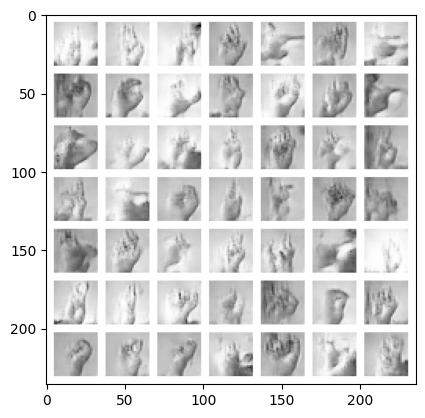

In [15]:
generator_optimizer = Adam(1.5e-4,0.5)
discriminator_optimizer = Adam(1.5e-4,0.5)
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE, 1)
generator = build_generator(SEED_SIZE)
discriminator = build_discriminator(image_shape)
train(images, 30, BATCH_SIZE)
    